In [31]:
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn import datasets

In [30]:
boston_ds = datasets.load_boston()

In [12]:
# 
def rmse(objetivo, estimaciones):
    return np.sqrt(metrics.mean_squared_error(objetivo, estimaciones))
# R^2 ajustado
def adjusted_r2(objetivo, estimaciones, n, k):
    r2 = metrics.r2_score(objetivo, estimaciones)
    return 1 - (1-r2)*(n-1) / (n - k - 1)

def evaluar_modelo(objetivo, estimaciones, n, k):
    return {
        "rmse": rmse(objetivo, estimaciones),
        "mae": metrics.mean_absolute_error(objetivo, estimaciones),
        "adjusted_r2": adjusted_r2(objetivo, estimaciones, n, k)
           }

### Entrenamiento con todos los datos

In [13]:
# Modelo de regresion linea
modelo_ols = LinearRegression()
# Entrenamiento
modelo_ols.fit(X=boston_ds["data"], y=boston_ds["target"])
# Obtener las prediciones con el modelo "aprendido"
modelo_ols_preds = modelo_ols.predict(boston_ds["data"])

In [14]:
RESULTADOS = {}

In [33]:
N = boston_ds["data"].shape[0] # Tamaño de la muestra
# Obtencion de ols, error medio absoluto, error4 cuadrático medio
RESULTADOS["ols"] = evaluar_modelo(
    boston_ds["target"],
    modelo_ols_preds,
    N,
    len(modelo_ols.coef_)
)

RESULTADOS

{'ols': {'rmse': 4.679191295697281,
  'mae': 3.270862810900317,
  'adjusted_r2': 0.733789726372463}}

### Datos de entrenamiento y Datos de Prueba

In [34]:
from sklearn.model_selection import train_test_split

In [35]:
# Que es esto?
train_test_split?

In [36]:
# Dimensiones originales de la data
boston_ds["data"].shape

(506, 13)

In [37]:
# Devuelve X (de entrenamiento y prueba), y (de entrenamiento y prueba)
X_train, X_test, y_train, y_test = train_test_split(
     boston_ds["data"], boston_ds["target"],# Se le pasa todas las X y todas las y
     test_size=0.33, random_state=13 # usar 33% como datos de prueba (ojo es aleatorio!!!), semilla de random=13
)

In [38]:
# Nuevas dimensiones de la data de entrenamiento
print(X_train.shape, y_train.shape)

(339, 13) (339,)


In [39]:
# Dimensiones de la data de prueba
print(X_test.shape, y_test.shape)

(167, 13) (167,)


In [40]:
# Nuevo entrenamiento con los "nuevos datos de entrenamiento y pruebas"
modelo_ols = LinearRegression()
modelo_ols.fit(X=X_train, y=y_train)
modelo_ols_train_preds = modelo_ols.predict(X_train)

In [41]:
RESULTADOS["ols_train"] = evaluar_modelo(
    y_train,
    modelo_ols_train_preds,
    X_train.shape[0],
    len(modelo_ols.coef_)
)

In [42]:
modelo_ols_test_preds = modelo_ols.predict(X_test)

RESULTADOS["ols_test"] = evaluar_modelo(
    y_test,
    modelo_ols_test_preds,
    X_test.shape[0],
    len(modelo_ols.coef_)
)
RESULTADOS

{'ols': {'rmse': 4.679191295697281,
  'mae': 3.270862810900317,
  'adjusted_r2': 0.733789726372463},
 'ols_train': {'rmse': 4.7217324545168475,
  'mae': 3.3008679922153576,
  'adjusted_r2': 0.7314907015939042},
 'ols_test': {'rmse': 4.784178251750699,
  'mae': 3.5584337209098265,
  'adjusted_r2': 0.6887158654171615}}

In [50]:
# Mejor vista
import pandas as pd

In [51]:
pd.DataFrame(RESULTADOS)

ols_train  ols_test
rmse          4.794269  4.552365
mae           3.376419  3.148256
adjusted_r2   0.728804  0.702889

Vemos que al separar los datos de entrenamiento y los de test se obtiene un resultado peor que al evaluar los datos de test.

Podríamos parar aquí y decir *"El error RMSE de mi modelo es 4.679191"*, y podríamos pensar que esta todo bien ya que no hemos entrenado el modelo en los datos que hemos usado para evaluarlo.

Pero estaríamos en un grave error. ¿Por qué? 

Recuerde que hemos usado un `random_state=13` para la función `train_test_split` que garantiza que la separación de entrenamiento y test sea siempre la misma. Podemos usar cualquier número para este argumento.

Qué pasa si usamos por ejemplo `random_state=42`?

In [52]:
# Vaciamos la variable
RESULTADOS = {}

X_train, X_test, y_train, y_test = train_test_split(
     boston_ds["data"], boston_ds["target"],
     test_size=0.33, random_state=42
)


modelo_ols = LinearRegression()
modelo_ols.fit(X=X_train, y=y_train)
modelo_ols_train_preds = modelo_ols.predict(X_train)
modelo_ols_test_preds = modelo_ols.predict(X_test)


RESULTADOS["ols_train"] = evaluar_modelo(
    y_train,
    modelo_ols_train_preds,
    X_train.shape[0],
    len(modelo_ols.coef_)
)

RESULTADOS["ols_test"] = evaluar_modelo(
    y_test,
    modelo_ols_test_preds,
    X_test.shape[0],
    len(modelo_ols.coef_)
)

pd.DataFrame(RESULTADOS)

ols_train  ols_test
rmse          4.794269  4.552365
mae           3.376419  3.148256
adjusted_r2   0.728804  0.702889

¡El error en los datos de test es menor que en los de entrenamiento! ¿Por qué? Sencillamente, por que ha dado la casualidad de que hemos separado los datos de una forma que los datos de test son muy fáciles de estimar.

Para ver la magnitud del error en el que estamos cayendo al hacer una sola separación entre test y entrenamiento, vamos a probar un monton de semillas y ver cual es el rango del error que se puede obtener 

In [53]:
model=LinearRegression()
results = []
# Usaremos muchas seed (semillas)
def test_seed(seed):
    X_train, X_test, y_train, y_test = train_test_split(
     boston_ds["data"], boston_ds["target"],
     test_size=0.33, random_state=seed
    )
    test_preds = model.fit(X_train, y_train).predict(X_test)
    seed_rmse = rmse(y_test, test_preds)
    results.append([seed_rmse, seed])

In [54]:
# Unas mil pruebas
for i in range(1000):
    test_seed(i)

In [59]:
# Veamos los primeros 5 rmse
results[:5]


[[5.1535019008476795, 0],
 [4.549557752626558, 1],
 [4.81796657714761, 2],
 [4.822833248024294, 3],
 [5.559184699608022, 4]]

In [60]:
# Ordenar en funcion de la primera columna de menor a mayor
results_sorted = sorted(results, key=lambda x: x[0], reverse=False)

In [61]:
# Mostrar el menor y su semilla
results_sorted[0]

[3.6313142170769503, 635]

In [62]:
# Mostrar el mayor y su semilla
results_sorted[-1]

[6.7880547140031355, 645]

**Validación Cruzada (Cross Validation)**

Vemos que entre la semilla con menor error de test y la semilla con mayor error hay una diferencia casi del doble!

Una forma de evitar el cometer este error es mediante la **Validación cruzada**

![cross_val](CrossValidation.jpg)

In [65]:
# Hacemos 10 particiones y luego la media de los errores
# Se evita seleccionar una particion optimista o partición pesimista
from sklearn.model_selection import cross_val_score

In [66]:
modelo_ols = LinearRegression()
X = boston_ds["data"]
y = boston_ds["target"]

resultados_validación_cruzada = cross_val_score(
    estimator=modelo_ols, # modelo de regresion sin ajustar
    X=X, # data x de entrenamiento
    y=y, # data y de entrenamiento
    scoring="neg_mean_squared_error", # error medio cuadrados negativos (de sckit learn)
    cv=10  # número de particiones
)

In [67]:
resultados_validación_cruzada

array([  -9.28694671,  -14.15128316,  -14.07360615,  -35.20692433,
        -31.88511666,  -19.83587796,   -9.94726918, -168.37537954,
        -33.32974507,  -10.96041068])

In [69]:
# Obtencion de la media de todas las particiones
resultados_validación_cruzada.mean()

-34.705255944524815

In [70]:
# Definimos una función para probar con más particiones
def rmse_cross_val(estimator, X, y):
    y_pred = estimator.predict(X)
    return np.sqrt(metrics.mean_squared_error(y, y_pred))

In [72]:
resultados_cv = []
# Obtener la media cuadrada desde 10 a 200 particiones
for i in range(10,200):
    cv_rmse = cross_val_score(
        estimator=modelo_ols, 
        X=X,
        y=y,
        scoring=rmse_cross_val, 
        cv=i
    ).mean()
    resultados_cv.append(cv_rmse)

In [75]:
%matplotlib inline
import matplotlib.pyplot as plt
resultados_cv

[5.180845679340244,
 5.1504016390750955,
 5.188486547696048,
 4.982056168387077,
 4.8244108491288555,
 5.00115982529476,
 4.900031598511857,
 4.914981416499195,
 4.811038311477211,
 4.835817843110356,
 4.818919446215456,
 4.703170671787213,
 4.707988627335751,
 4.77300540373869,
 4.7178993244188705,
 4.704517219661335,
 4.651327045931011,
 4.639826288747595,
 4.61404480328845,
 4.690115661900143,
 4.638258497383998,
 4.558722040657654,
 4.543218533102675,
 4.60719977100715,
 4.585717873569519,
 4.556884022804703,
 4.509588802299884,
 4.516286775554991,
 4.504758914205914,
 4.475075617397179,
 4.539653587027497,
 4.537245207416609,
 4.485551859506946,
 4.483388851812037,
 4.449545722534202,
 4.456658347041789,
 4.400901575954629,
 4.399979641006618,
 4.425276215146891,
 4.459149172573504,
 4.444661510147168,
 4.396795896209315,
 4.400943210769738,
 4.402141027801888,
 4.42703104335654,
 4.399609599065137,
 4.376834922705357,
 4.380940348660674,
 4.376601180405562,
 4.3686891827021,
 4.3

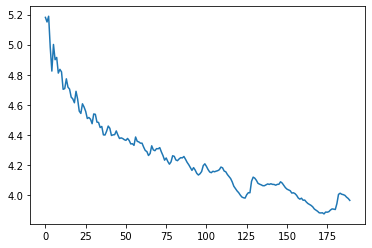

In [74]:
# Graficamos el rsme
plt.plot(resultados_cv)

In [70]:
# Usaremos el cross_validate de sckit learn
from sklearn.model_selection import cross_validate
scoring = {"mae": "neg_mean_absolute_error", "rmse": rmse_cross_val}
estimator = modelo_ols
scores = cross_validate(estimator, boston_ds["data"],
                        boston_ds["target"], scoring=scoring,
                        cv=100, # 10 particiones rmse se acerca a 5, con 100 se acerca a 4
                        return_train_score=True)  # False solo muestra mae y rmse de test
                                                   # True agrega mae y rsme de la data de entrenamiento

In [71]:
pd.DataFrame(scores).mean()
# Tiempo de ajuste, de evaluacion en segundos

fit_time      0.001100
score_time    0.000710
test_mae     -3.511687
train_mae    -3.270699
test_rmse     4.184166
train_rmse    4.676971
dtype: float64